In [1]:
# Description de la composition des clusters

# Library ----------------------------------------------------------------
library(dplyr)
library(tidyr)
library(ggplot2)
library(sondr)
library(clessnize)
library(ggtext)
library(tidytext)

# 1. Load Data and Clustering Results ---------------------------
kmeans_result <- readRDS("../../../_PrivateFolder_datagotchi_federal_2025/data/clustering/qc2022/03_pilot1_kmeans.rds")
df_pilot1_2022 <- readRDS("../../../_PrivateFolder_datagotchi_federal_2025/data/clustering/qc2022/03_pilot1_2022.rds")
cluster_means <- read.csv("../../../_PrivateFolder_datagotchi_federal_2025/data/clustering/qc2022/03_pilot1_clusters_desc.csv")
df_pilot1_2022_with_issues <- readRDS("../../../_SharedFolder_datagotchi_federal_2024/data/clustering/qc_2022/datagotchiQuebec2022_pilote1Clean.rds")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# Avoir une liste des variables utilisées pour faire le clustering
# (Exclure "id" et toutes les variables commençant par "cluster")
variablesUsedForClustering<- names(df_pilot1_2022)[!grepl("^cluster|^id$", names(df_pilot1_2022))]

# Créer une nouvelle dataframe avec ces variables
dfUsedForClustering <- df_pilot1_2022

# Chemin d’enregistrement des graphiques
output_path <- "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022"

dfUsedForClustering$cluster <- as.factor(kmeans_result$cluster)


In [3]:
# Créer une fonction pour calculer l'importance relative de chaque variable -----------------------------

calculate_importance <- function(data, variables) {
  importance_scores <- sapply(variables, function(var) {
    overall_mean <- mean(data[[var]], na.rm = TRUE)
    cluster_means <- tapply(data[[var]], data$cluster, mean, na.rm = TRUE)
    abs_diff <- abs(cluster_means - overall_mean) / sd(data[[var]], na.rm = TRUE)
    return(mean(abs_diff, na.rm = TRUE))
  })
  importance_scores <- importance_scores / sum(importance_scores)  # Normaliser pour obtenir des proportions
  return(importance_scores)
}

# Calculer l'importance relative pour les variables d'enjeux
importance_scores <- calculate_importance(dfUsedForClustering, variablesUsedForClustering)
print(importance_scores)


                           act_Gym                           act_Walk 
                       0.005008155                        0.004056627 
                           act_Run                           act_Yoga 
                       0.005328324                        0.007004296 
                         act_Other                           act_None 
                       0.005099301                        0.005206139 
                       act_Fishing                        act_Hunting 
                       0.011466852                        0.011247054 
         act_VisitsMuseumsGaleries     act_MotorizedOutdoorActivities 
                       0.008736669                        0.010080291 
                  act_Volunteering                 app_swag_Classique 
                       0.009573212                        0.004288048 
                   app_swag_Casual                     app_swag_Sport 
                       0.002503146                        0.005885807 
      

In [8]:
# Fonction pour décrire les personas ------------------------------------------------------
describe_personas <- function(data, kmeans_result, variables, persona_names = NULL, p_value_threshold = 0.01, effect_size_threshold = 0.5, proportion_diff_threshold = 0.1) {
  data$cluster <- as.factor(kmeans_result$cluster)
  
  variable_names <- variables
  persona_summary <- data %>%
    group_by(cluster) %>%
    summarise(across(all_of(variable_names), list(mean = ~mean(.x, na.rm = TRUE), sd = ~sd(.x, na.rm = TRUE))))
  
  print(persona_summary)
}

# Appliquer la description des personas
describe_personas(dfUsedForClustering, kmeans_result, variablesUsedForClustering)

# Préparation des données pour la visualisation des personas ----------------------------------------
all_data_viz <- data.frame()

for (cluster_value in levels(dfUsedForClustering$cluster)) {
  cluster_data <- dfUsedForClustering %>% filter(cluster == cluster_value)
  means <- sapply(variablesUsedForClustering, function(var) mean(cluster_data[[var]], na.rm = TRUE))
  overall_means <- sapply(variablesUsedForClustering, function(var) mean(dfUsedForClustering[[var]], na.rm = TRUE))
  
  # Identification des caractéristiques marquantes
  characteristic_vars <- sapply(variablesUsedForClustering, function(var) {
    if (all(dfUsedForClustering[[var]] %in% c(0, 1))) {
      prop_cluster <- mean(cluster_data[[var]], na.rm = TRUE)
      prop_overall <- mean(dfUsedForClustering[[var]], na.rm = TRUE)
      p_value <- prop.test(x = c(sum(cluster_data[[var]]), sum(dfUsedForClustering[[var]])), 
                           n = c(nrow(cluster_data), nrow(dfUsedForClustering)))$p.value
      prop_diff <- abs(prop_cluster - prop_overall)
      return(ifelse(p_value < 0.05 && prop_diff > 0.3, ifelse(prop_cluster > prop_overall, "green", "red"), "black"))
    } else {
      t_test <- t.test(cluster_data[[var]], dfUsedForClustering[[var]])
      effect_size <- abs(t_test$estimate[1] - t_test$estimate[2]) / sd(dfUsedForClustering[[var]], na.rm = TRUE)
      return(ifelse(t_test$p.value < 0.05 && effect_size > 0.25, ifelse(t_test$estimate[1] > t_test$estimate[2], "green", "red"), "black"))
    }
  })

  # Calculs des proportions de femmes, d'immigrants, âge et revenu moyen
  perc_femmes <- mean(cluster_data$female, na.rm = TRUE) * 100
  perc_immigrants <- mean(cluster_data$immigrant, na.rm = TRUE) * 100
  age_mean <- mean(cluster_data$age, na.rm = TRUE)
  revenu_moyen <- mean(cluster_data$ses_income, na.rm = TRUE)
  
  # Préparation des données pour le graphique
  data_viz <- data.frame(Variable = variablesUsedForClustering, Mean = means, Overall = overall_means, Cluster = cluster_value)
  data_viz$Color <- characteristic_vars
  data_viz$Persona <- paste("Persona", cluster_value)
  all_data_viz <- rbind(all_data_viz, data_viz)
  
  # Génération du prompt de suggestion de noms
  cat(paste0("\nPour le persona ", cluster_value, " :\n",
             "Variables supérieures :\n",
             if (any(characteristic_vars == "green")) {
               paste(variablesUsedForClustering[characteristic_vars == "green"], collapse = "\n")
             } else {
               "Aucune variable supérieure ne se distingue fortement."
             },
             "\nVariables inférieures :\n",
             if (any(characteristic_vars == "red")) {
               paste(variablesUsedForClustering[characteristic_vars == "red"], collapse = "\n")
             } else {
               "Aucune variable inférieure ne se distingue fortement."
             },
             "\n\nCe cluster est composé de ", round(perc_femmes, 1), "% de femmes, ", 
             round(perc_immigrants, 1), "% d'immigrants, un âge moyen de ", round(age_mean, 1), 
             " ans et un revenu moyen de ", round(revenu_moyen, 1), " k$.\n"
  ))
}


# A tibble: 6 × 155
# A tibble: 6 × 155


  cluster act_Gym_mean act_Gym_sd act_Walk_mean act_Walk_sd act_Run_mean
  <fct>          <dbl>      <dbl>         <dbl>       <dbl>        <dbl>
1 1             0.127       0.334         0.639       0.481       0.0837
2 2             0.139       0.346         0.589       0.493       0.0977
3 3             0.0829      0.276         0.707       0.456       0.0442
4 4             0.185       0.390         0.669       0.472       0.169 
5 5             0.158       0.366         0.633       0.484       0.0935
6 6             0.109       0.313         0.606       0.490       0.0848
# ℹ 149 more variables: act_Run_sd <dbl>, act_Yoga_mean <dbl>,
#   act_Yoga_sd <dbl>, act_Other_mean <dbl>, act_Other_sd <dbl>,
#   act_None_mean <dbl>, act_None_sd <dbl>, act_Fishing_mean <dbl>,
#   act_Fishing_sd <dbl>, act_Hunting_mean <dbl>, act_Hunting_sd <dbl>,
#   act_VisitsMuseumsGaleries_mean <dbl>, act_VisitsMuseumsGaleries_sd <dbl>,
#   act_MotorizedOutdoorActivities_mean <dbl>,
#   act_MotorizedOutdoo


Pour le persona 1 :
Variables supérieures :
female
Variables inférieures :
male

Ce cluster est composé de 99.8% de femmes, 4.6% d'immigrants, un âge moyen de 0.6 ans et un revenu moyen de 0.4 k$.

Pour le persona 2 :
Variables supérieures :
male
Variables inférieures :
female

Ce cluster est composé de 0.5% de femmes, 6.4% d'immigrants, un âge moyen de 0.7 ans et un revenu moyen de 0.4 k$.

Pour le persona 3 :
Variables supérieures :
act_transport_Walk
vehicule_noCar
ses_income_i1to30
Variables inférieures :
act_MotorizedOutdoorActivities
cons_Meat
ses_dwelling_detachedHouse
act_transport_Car
vehicule_Voiture
ses_income

Ce cluster est composé de 60.2% de femmes, 12.2% d'immigrants, un âge moyen de 0.6 ans et un revenu moyen de 0.2 k$.


Pour le persona 1 :
Variables supérieures :
female
Variables inférieures :
male

Ce cluster est composé de 99.8% de femmes, 4.6% d'immigrants, un âge moyen de 0.6 ans et un revenu moyen de 0.4 k$.

Pour le persona 2 :
Variables supérieures :
male
Var


Pour le persona 4 :
Variables supérieures :
act_VisitsMuseumsGaleries
act_Volunteering
immigrant
educ
Variables inférieures :
langFr
ses_ethn_White
age

Ce cluster est composé de 47.6% de femmes, 73.4% d'immigrants, un âge moyen de 0.4 ans et un revenu moyen de 0.4 k$.


Pour le persona 4 :
Variables supérieures :
act_VisitsMuseumsGaleries
act_Volunteering
immigrant
educ
Variables inférieures :
langFr
ses_ethn_White
age

Ce cluster est composé de 47.6% de femmes, 73.4% d'immigrants, un âge moyen de 0.4 ans et un revenu moyen de 0.4 k$.



Pour le persona 5 :
Variables supérieures :
act_VisitsMuseumsGaleries
ses_gai
ses_bisex
Variables inférieures :
ses_hetero
age

Ce cluster est composé de 36.7% de femmes, 14.4% d'immigrants, un âge moyen de 0.5 ans et un revenu moyen de 0.4 k$.


Pour le persona 5 :
Variables supérieures :
act_VisitsMuseumsGaleries
ses_gai
ses_bisex
Variables inférieures :
ses_hetero
age

Ce cluster est composé de 36.7% de femmes, 14.4% d'immigrants, un âge moyen de 0.5 ans et un revenu moyen de 0.4 k$.



Pour le persona 6 :
Variables supérieures :
act_Fishing
act_Hunting
act_MotorizedOutdoorActivities
act_transport_SUV
vehicule_VUS
ses_income
Variables inférieures :
act_transport_Car
vehicule_Voiture

Ce cluster est composé de 50.3% de femmes, 6.1% d'immigrants, un âge moyen de 0.6 ans et un revenu moyen de 0.5 k$.


Pour le persona 6 :
Variables supérieures :
act_Fishing
act_Hunting
act_MotorizedOutdoorActivities
act_transport_SUV
vehicule_VUS
ses_income
Variables inférieures :
act_transport_Car
vehicule_Voiture

Ce cluster est composé de 50.3% de femmes, 6.1% d'immigrants, un âge moyen de 0.6 ans et un revenu moyen de 0.5 k$.


There were 30 warnings (use warnings() to see them)


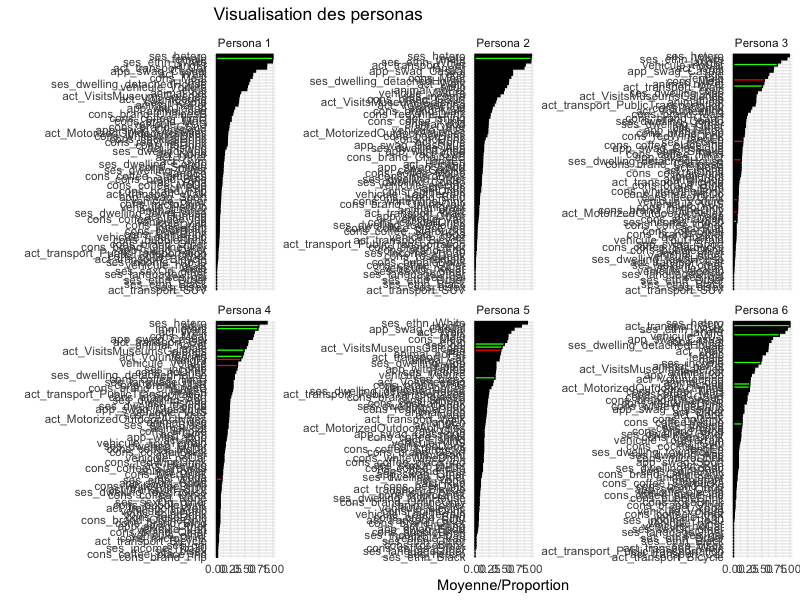

In [9]:
# Tri des données pour le graphique
all_data_viz <- all_data_viz %>%
  group_by(Persona) %>%
  arrange(desc(Mean)) %>%
  ungroup()

# Sauvegarder le graphique
ggplot(all_data_viz, aes(x = reorder_within(Variable, Mean, Persona), y = Mean, fill = Color)) +
  geom_bar(stat = "identity", color = "black", show.legend = FALSE) +
  scale_fill_identity() +
  labs(title = "Visualisation des personas", x = "", y = "Moyenne/Proportion") +
  theme_minimal() +
  coord_flip() +
  facet_wrap(~ Persona, scales = "free_y") +
  scale_x_reordered()

In [25]:
 # Génération du prompt de suggestion de noms
 cat(paste0("\nPour le persona ", cluster_value, " :\n",
 "\nLes caractéristiques suivantes définissent ce cluster par leur distinction marquée :\n\n",
 "Variables supérieures (le cluster se démarque par des valeurs élevées) :\n",
 if (any(characteristic_vars == "green")) {
   paste(variablesUsedForClustering[characteristic_vars == "green"], collapse = "\n")
 } else {
   "Aucune variable supérieure ne se distingue fortement."
 },
 "\n\nVariables inférieures (le cluster se démarque par des valeurs faibles) :\n",
 if (any(characteristic_vars == "red")) {
   paste(variablesUsedForClustering[characteristic_vars == "red"], collapse = "\n")
 } else {
   "Aucune variable inférieure ne se distingue fortement."
 },
 "\n\nCe cluster est composé de ", round(perc_femmes, 1), "% de femmes, ", 
 round(perc_immigrants, 1), "% d'immigrants, un âge moyen de ", round(age_mean, 1), 
 " ans et un revenu moyen de ", round(revenu_moyen, 1), " k$.\n",
 "\nSuggérez un nom qui reflète bien ces caractéristiques.\n",
 "Tu peux donner un prénom significatif suivi par un deux-points (:) et un nom descriptif.\n",
 "Finalement, décris la persona en 2-3 phrases, en tenant compte des scores d'importance et de la direction (élevée ou faible) de chaque variable pour ce cluster.\n\n"))


Pour le persona 6 :

Les caractéristiques suivantes définissent ce cluster par leur distinction marquée :

Variables supérieures (le cluster se démarque par des valeurs élevées) :
act_Fishing
act_Hunting
act_MotorizedOutdoorActivities
act_transport_SUV
vehicule_VUS
ses_income

Variables inférieures (le cluster se démarque par des valeurs faibles) :
act_transport_Car
vehicule_Voiture

Ce cluster est composé de 50.3% de femmes, 6.1% d'immigrants, un âge moyen de 0.6 ans et un revenu moyen de 0.5 k$.

Suggérez un nom qui reflète bien ces caractéristiques.
Tu peux donner un prénom significatif suivi par un deux-points (:) et un nom descriptif.
Finalement, décris la persona en 2-3 phrases, en tenant compte des scores d'importance et de la direction (élevée ou faible) de chaque variable pour ce cluster.



Pour le persona 6 :

Les caractéristiques suivantes définissent ce cluster par leur distinction marquée :

Variables supérieures (le cluster se démarque par des valeurs élevées) :
act_Fis